In [60]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
# import matplotlib.pyplot as plot
# import matplotlib.pyplot as plt
import pymysql
import statsmodels.api as sm
import matplotlib.pyplot as plt

db_connection = pymysql.connect(host='54.67.38.144',user='shivangi',password='Shivangi@123',db='ccbst_migrate')

In [61]:
def q1():
    init_df=pd.read_sql_query("SELECT s.id,s.chart_of_activity_id,s.created_at,s.campus_id,ac.name from student_inquiries s join chart_of_activities ac on s.chart_of_activity_id=ac.id ",db_connection)
    #mask=init_df['name'].isin(['Newspaper / Job Classified/Employment News','CCBSTCollege.com Instagram', 'Laptops','CCBST.CA (SEO) Enrollment Resources - Phone Call', 'Friend','Alex - PPC and Google Adword - 5968', 'Brampton Transit-Sambrook','Vikas/ PPC and Google Adwords - 7293','TV Ad - Bell Media', 'Flyer', 'Hellobar - Pop up','CCBSTCollege.com Facebook', 'Zendesk','Privatecareercollege.ca Facebook'])
    df50=init_df
    df50['name']=df50['name'].str.replace("/","-")
    df50['Date'] = pd.to_datetime(df50['created_at'])
    df50=df50.drop('created_at',axis=1)
    df50['timestamp'] = pd.to_datetime(df50['Date'])
    df50['Date'] = df50['timestamp'].dt.date
    df50.drop('timestamp',axis=1)
    df50= df50.groupby('Date')['name'].value_counts().reset_index(name='Frequency')
    return df50

In [62]:
# f1 = q1()['name'].unique()
# f1

In [63]:
# f2 = q2()['name'].unique()
# f2

In [64]:
# f3 = q3()['name'].unique()
# f3

In [65]:
# f3.shape

In [66]:
# set(f1)&set(f2)

In [67]:
# set(f1)&set(f3)

In [68]:
set(f1).issubset(set(f2))

NameError: name 'f1' is not defined

In [69]:
set(f1).issubset(set(f3))

NameError: name 'f1' is not defined

In [70]:
def q2():
    df1=pd.read_sql_query("SELECT DISTINCT nmr.id,coa.name,nmr.coa_id,nmr.status,nmr.number_of_inquiry,nmr.converted_student,nmr.campus,invoices.id as invoice_id,ids.chart_of_activity_id,invoices.amount_total,invoices.created_at,coa.do_marketing_status FROM `new_marketing_reports` as nmr LEFT JOIN chart_of_activities as coa ON nmr.coa_id = coa.id LEFT JOIN invoice_details as ids ON coa.id = ids.chart_of_activity_id LEFT JOIN invoices ON ids.invoice_id = invoices.id WHERE nmr.STATUS in (0,1) AND nmr.number_of_inquiry != 0 AND invoices.created_at > '2019-05-31 20:00:00' AND do_marketing_status =1 GROUP BY invoice_id",db_connection)
    df1['name']=df1['name'].str.replace("/","-")
    #df1['name']= df1['name'].str.replace('Enrollment Resources/Vikas/ PPC and Google Adwords - 7293','Vikas/ PPC and Google Adwords - 7293')

    return df1
    

In [71]:
def q3():
    df=pd.read_sql_query("SELECT DISTINCT nmr.id,coa.name,nmr.coa_id,nmr.status,nmr.number_of_inquiry,nmr.converted_student,nmr.campus,invoices.id as invoice_id,ids.chart_of_activity_id,invoices.amount_total,nmr.created_at,coa.do_marketing_status FROM `new_marketing_reports` as nmr LEFT JOIN chart_of_activities as coa ON nmr.coa_id = coa.id LEFT JOIN invoice_details as ids ON coa.id = ids.chart_of_activity_id LEFT JOIN invoices ON ids.invoice_id = invoices.id WHERE nmr.STATUS in (0,1) AND nmr.number_of_inquiry != 0 AND nmr.created_at > '2019-06-01 20:00:00' AND do_marketing_status = 1 GROUP BY nmr.id",db_connection)
    df['name']=df['name'].str.replace("/","-")
    #mask1=df['name'].isin(['Newspaper / Job Classified/Employment News','CCBSTCollege.com Instagram', 'Laptops','CCBST.CA (SEO) Enrollment Resources - Phone Call', 'Friend','Alex - PPC and Google Adword - 5968', 'Brampton Transit-Sambrook','Vikas/ PPC and Google Adwords - 7293','TV Ad - Bell Media', 'Flyer', 'Hellobar - Pop up','CCBSTCollege.com Facebook', 'Zendesk','Privatecareercollege.ca Facebook'])
    #df=df[mask1]
    return df

In [72]:
def merge1(df50, name):
    vpcc=df50.loc[df50.name == name]
    vpcc=vpcc.drop(['name'],axis=1)
    vpcc= vpcc.rename(columns={'Date':'ds', 'Frequency':'y'})
    ccbst_vpcc=Prophet()
    ccbst_vpcc.fit(vpcc)
    future = ccbst_vpcc.make_future_dataframe(periods =210, freq ='D')
    forecast = ccbst_vpcc.predict(future)
    abc=forecast
    start_date='2019-06-01'
    pp=(forecast['ds']> start_date)
    abc=abc.loc[pp]
    abc=abc[["ds","yhat"]]
    abc=abc.rename(columns={'ds':'Date','yhat':'Predicted inquiries'})
    abc['month_year'] = pd.to_datetime(abc['Date']).dt.to_period('M')
    abc.drop('Date',axis=1)
    abc1=abc.groupby(["month_year"])["Predicted inquiries"].sum().reset_index(name="sum_of_predicted_inquries")
    abc1.sum_of_predicted_inquries = abc1.sum_of_predicted_inquries.round()
    return abc1

In [73]:
def merge2(df1, name):
    df1=df1.loc[df1.name == name]
    df1['Date'] = pd.to_datetime(df1['created_at'])
    df1=df1.drop('created_at',axis=1)
    df1['timestamp'] = pd.to_datetime(df1['Date'])
    df1['Date'] = df1['timestamp'].dt.date
    df1.drop('timestamp',axis=1)
    df2=df1[["amount_total","Date"]]
    df2[df2.duplicated()] 
    df2=df2.groupby(["Date"])["amount_total"].sum().reset_index(name="total spending")
    df2['Date'] = pd.to_datetime(df2['Date'])
    df2['month_year'] = pd.to_datetime(df2['Date']).dt.to_period('M')
    df2.drop("Date",axis=1)
    amount=df2.groupby(["month_year"])["total spending"].sum().reset_index(name="sum_of_total_spending")
    return amount

In [74]:
def merge3(df,amount, name):    
    df=df.loc[df.name == name]
    df=df[["number_of_inquiry","converted_student","campus","name","created_at"]]
    df['month_year'] = pd.to_datetime(df['created_at']).dt.to_period('M')
    df.drop("created_at",axis=1)
    grp_inq=df.groupby(["month_year"])["number_of_inquiry"].sum().reset_index(name="sum_of_inquries")
    grp_co=df.groupby(["month_year"])["converted_student"].sum().reset_index(name="sum_of_converted")
    grp_merge=pd.merge(grp_inq,grp_co,left_on='month_year',right_on='month_year')
    grp_merge
    final_merge=pd.merge(grp_merge,amount, on = "month_year",how='right')
    final_merge['conversion_rate']=final_merge.sum_of_converted/final_merge.sum_of_inquries
    final_merge['lead_value']=final_merge.sum_of_total_spending	/final_merge.sum_of_inquries
    return final_merge

In [75]:
def fillna_moving_avereage(data, window=3):
    result = data[:window]
    moving_avg = 0
    for index in range(window, len(data)):
        moving_avg = sum(data[index-window:index])/window
        result.append(moving_avg)
    return result 

In [76]:
def f_merge(abc1,final_merge):
    merged_Frame = pd.merge(final_merge,abc1, on = "month_year",how='right')
    merged_Frame['lead_value'].fillna(0, inplace=True)
    merged_Frame=merged_Frame.round()
    x = merged_Frame['lead_value'].to_list()

    merged_Frame['predicted_lead_value'] = fillna_moving_avereage(x)
    merged_Frame=merged_Frame[5:]
    merged_Frame['Predicted_Budget']=(round(merged_Frame.sum_of_predicted_inquries*merged_Frame.predicted_lead_value))
    ax=merged_Frame.plot(x="month_year", y=["sum_of_total_spending", "Predicted_Budget"], kind="bar")
    ax.figure.savefig("budget prediction_"+name+'.png')
    return merged_Frame

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.
<ipython-input-73-64d562b69172>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Date'] = pd.to_datetime(df1['created_at'])
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Zendesk


<ipython-input-73-64d562b69172>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Date'] = pd.to_datetime(df1['created_at'])
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CCBST.CA (SEO) Enrollment Resources - Phone Call


<ipython-input-73-64d562b69172>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Date'] = pd.to_datetime(df1['created_at'])
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CCBSTCollege.com Instagram


<ipython-input-73-64d562b69172>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Date'] = pd.to_datetime(df1['created_at'])
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


secondcareerfunding.ca


<ipython-input-73-64d562b69172>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Date'] = pd.to_datetime(df1['created_at'])
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Brampton Transit-Sambrook


<ipython-input-73-64d562b69172>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Date'] = pd.to_datetime(df1['created_at'])
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Green Lotus- PPC 


<ipython-input-73-64d562b69172>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Date'] = pd.to_datetime(df1['created_at'])
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Secondcareerfunding.ca Facebook


<ipython-input-73-64d562b69172>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Date'] = pd.to_datetime(df1['created_at'])
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CCBSTCollege.com Facebook


<ipython-input-73-64d562b69172>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Date'] = pd.to_datetime(df1['created_at'])
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Flyer


<ipython-input-73-64d562b69172>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Date'] = pd.to_datetime(df1['created_at'])
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Vikas- PPC and Google Adwords - 7293


<ipython-input-73-64d562b69172>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Date'] = pd.to_datetime(df1['created_at'])
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Newspaper - Job Classified-Employment News


<ipython-input-73-64d562b69172>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Date'] = pd.to_datetime(df1['created_at'])
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Friend-Agent


<ipython-input-73-64d562b69172>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Date'] = pd.to_datetime(df1['created_at'])
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


Privatecareercollege.ca Facebook


<ipython-input-73-64d562b69172>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Date'] = pd.to_datetime(df1['created_at'])
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Job Fair - News paper


<ipython-input-73-64d562b69172>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Date'] = pd.to_datetime(df1['created_at'])
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


Hellobar - Pop up- Vikas


<ipython-input-73-64d562b69172>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Date'] = pd.to_datetime(df1['created_at'])
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Laptops


<ipython-input-73-64d562b69172>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Date'] = pd.to_datetime(df1['created_at'])
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CP24 (TV Ad - Bell Media)


<ipython-input-73-64d562b69172>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Date'] = pd.to_datetime(df1['created_at'])
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CCBST College (SEO) Nilesh Pujara


<ipython-input-73-64d562b69172>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Date'] = pd.to_datetime(df1['created_at'])


Alex - PPC and Google Adword - 5968


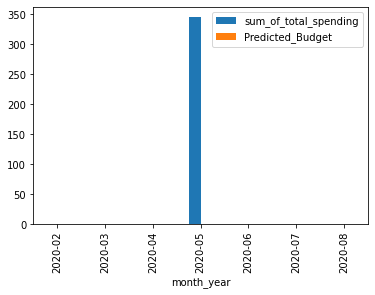

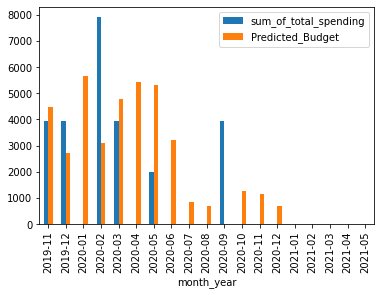

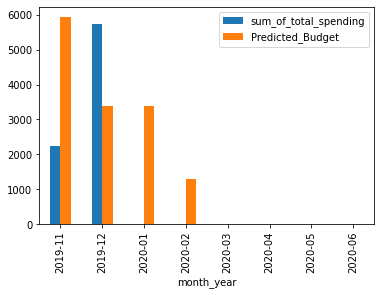

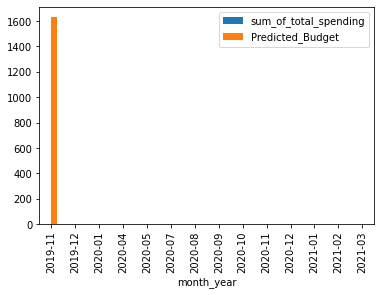

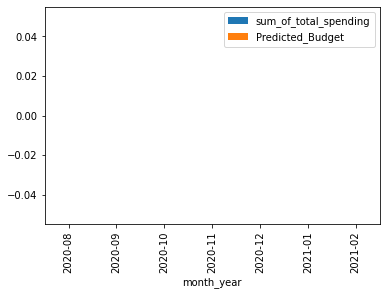

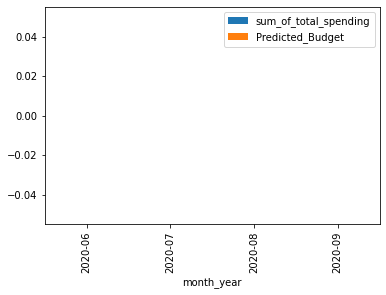

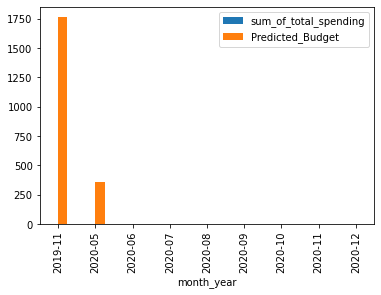

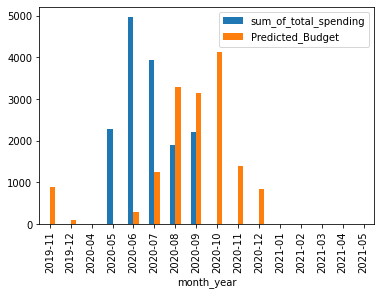

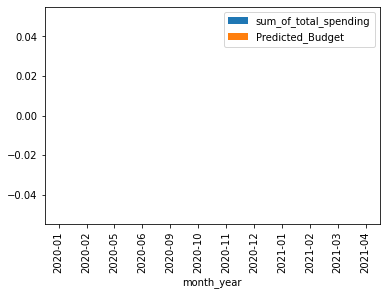

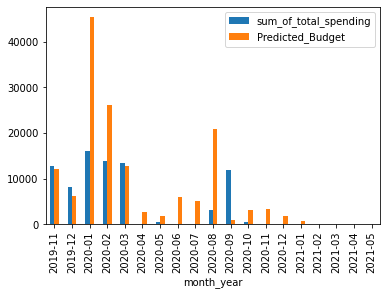

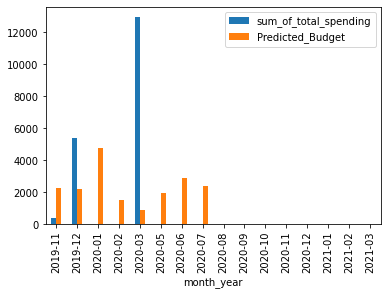

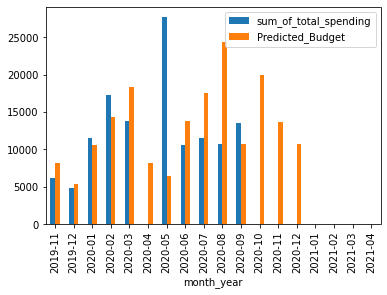

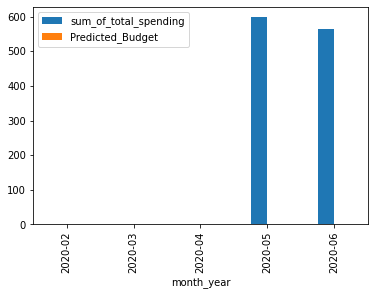

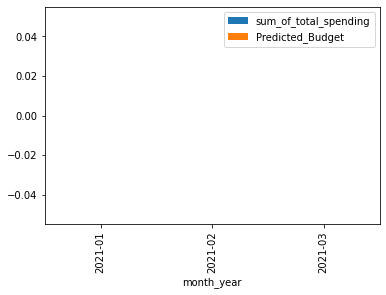

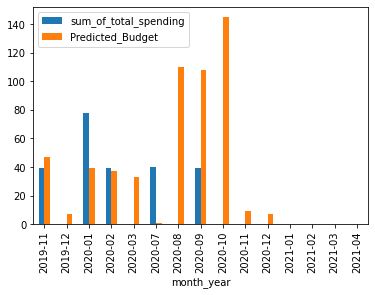

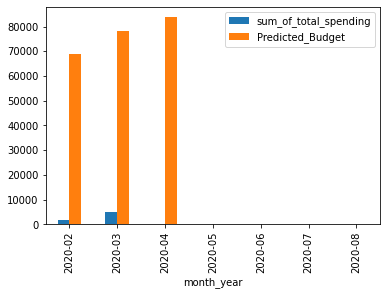

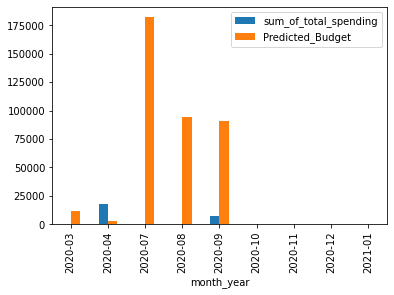

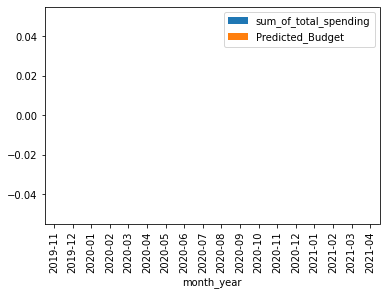

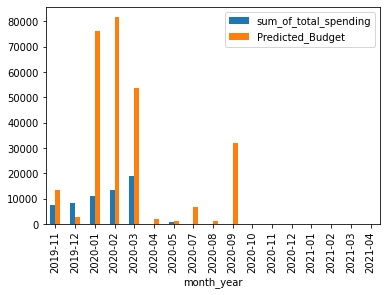

In [77]:
df1 = q1()
df2 = q2()
df3 = q3()

n1 = df1['name'].unique()
n2 = df2['name'].unique()
n3 = df3['name'].unique()

names = set(n1) & set(n2) & set(n3)

for name in names:
    abc1 = merge1(df1,name)
    amount = merge2(df2,name)
    final_merge = merge3(df3,amount,name)
    merged_Frame = f_merge(abc1,final_merge)
    print(name)
    
    

In [ ]:
names